In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper Functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Pre-processing

In [4]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [6]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [7]:
model = FCNN(config=config)
model

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

# Case 1: CombinedLoss (alpha=12500), Standardization

In [8]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [8]:
criterion = CombinedLoss(alpha=12500) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CombLoss_alph12500.pth',
            n_epochs=75) # n_epochs=2000)

Trainable Parameters: 149569
Resuming from epoch 62 with best val losses [408.56779269997133, 408.20439189945887, 400.8974964946782, 372.50386901295514, 360.6504362613783]
Epoch 63, Train Loss: 4.246e+02, Val Loss: 4.639e+02, Epoch Time: 304.34s
Patience counter: 1/50
Epoch 64, Train Loss: 4.282e+02, Val Loss: 4.906e+02, Epoch Time: 308.21s
Patience counter: 2/50
Epoch 65, Train Loss: 4.354e+02, Val Loss: 4.645e+02, Epoch Time: 305.02s
Patience counter: 3/50
Epoch 66, Train Loss: 4.226e+02, Val Loss: 5.013e+02, Epoch Time: 324.52s
Patience counter: 4/50
Epoch 67, Train Loss: 4.462e+02, Val Loss: 5.087e+02, Epoch Time: 312.22s
Patience counter: 5/50
Epoch 68, Train Loss: 4.309e+02, Val Loss: 5.013e+02, Epoch Time: 318.02s
Patience counter: 6/50
Epoch 69, Train Loss: 4.484e+02, Val Loss: 4.718e+02, Epoch Time: 312.29s
Patience counter: 7/50
Epoch 70, Train Loss: 4.230e+02, Val Loss: 4.751e+02, Epoch Time: 317.42s
Patience counter: 8/50
Epoch 71, Train Loss: 4.023e+02, Val Loss: 4.620e+02

In [9]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_CombLoss_alph12500.pth')
sgs_pred

Loaded model parameters from ./model_CombLoss_alph12500.pth


array([[[ 9.61502910e-01,  1.00034034e+00,  9.94687617e-01, ...,
         -1.79709896e-01, -1.72382981e-01, -1.76475048e-01],
        [ 1.04135108e+00,  1.02757144e+00,  1.01830196e+00, ...,
         -1.07137620e-01, -1.05437368e-01, -1.03818104e-01],
        [ 1.03039157e+00,  1.04815197e+00,  1.05835724e+00, ...,
         -7.45767504e-02, -6.96600452e-02, -7.05628842e-02],
        ...,
        [ 4.89730239e-01,  4.90635663e-01,  4.84758496e-01, ...,
         -5.06853342e-01, -3.81985605e-01, -5.19617975e-01],
        [ 5.06851077e-01,  5.09312034e-01,  5.01897573e-01, ...,
         -4.21657920e-01, -2.87799239e-01, -4.34045851e-01],
        [ 4.87025976e-01,  4.88169998e-01,  4.82347339e-01, ...,
         -5.27754188e-01, -3.99462402e-01, -5.40948033e-01]],

       [[-2.03510380e+00, -1.87055147e+00, -1.98105240e+00, ...,
          1.20005488e+00,  1.16400957e+00,  1.21403265e+00],
        [-1.94390011e+00, -1.78521657e+00, -1.90156770e+00, ...,
          1.17995358e+00,  1.14309418e

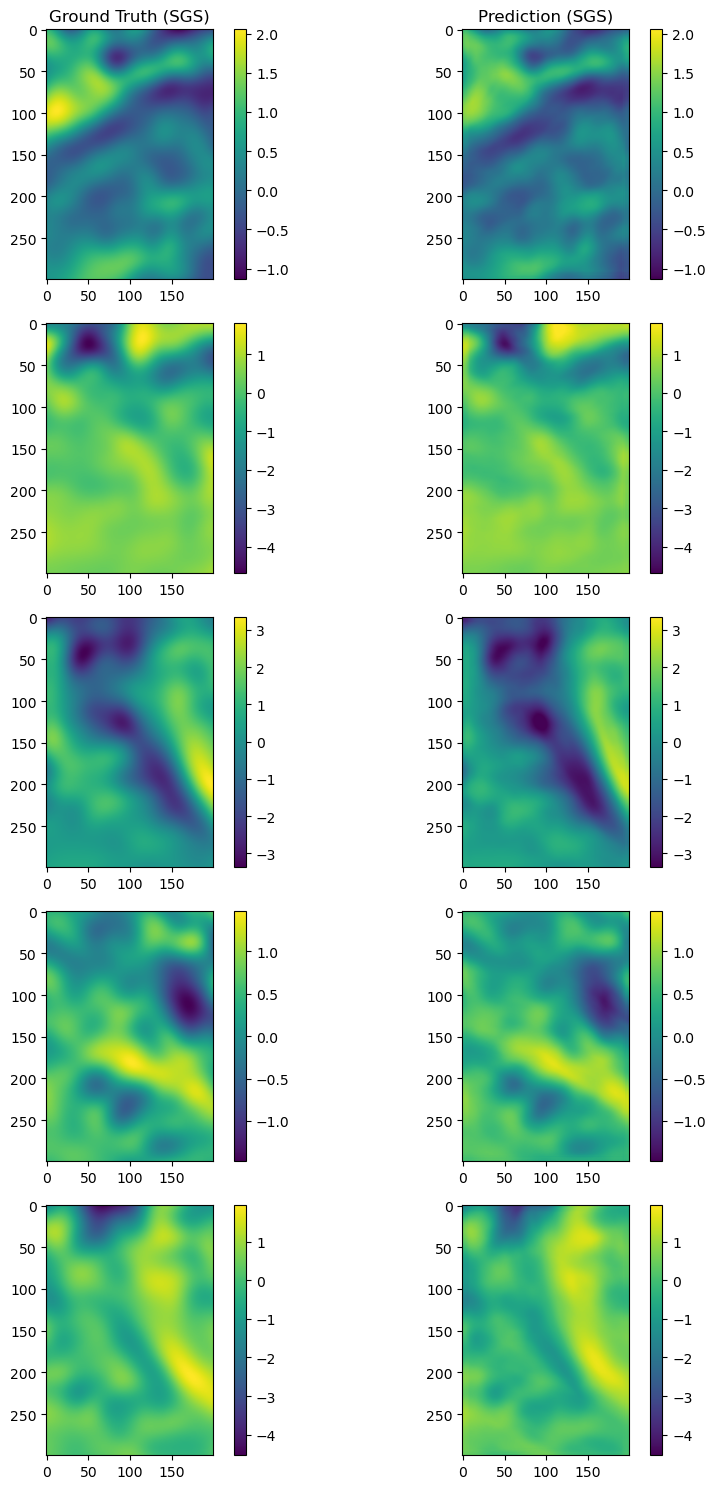

In [10]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

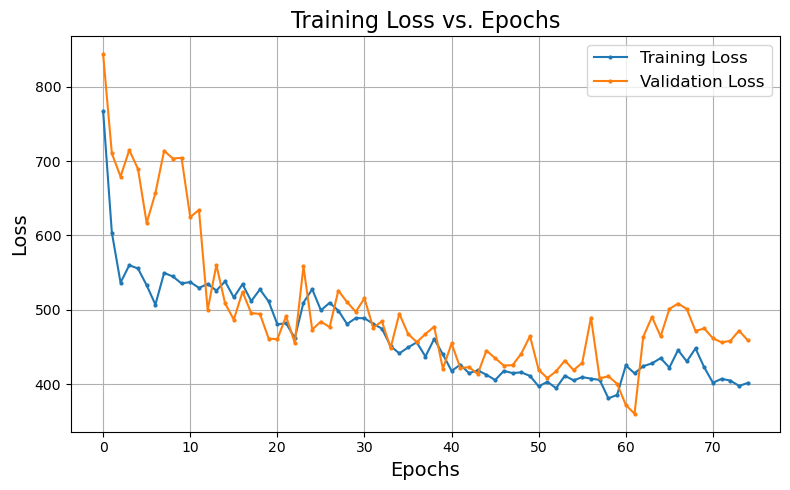

In [11]:
plot_train_val_losses(train_losses, val_losses)

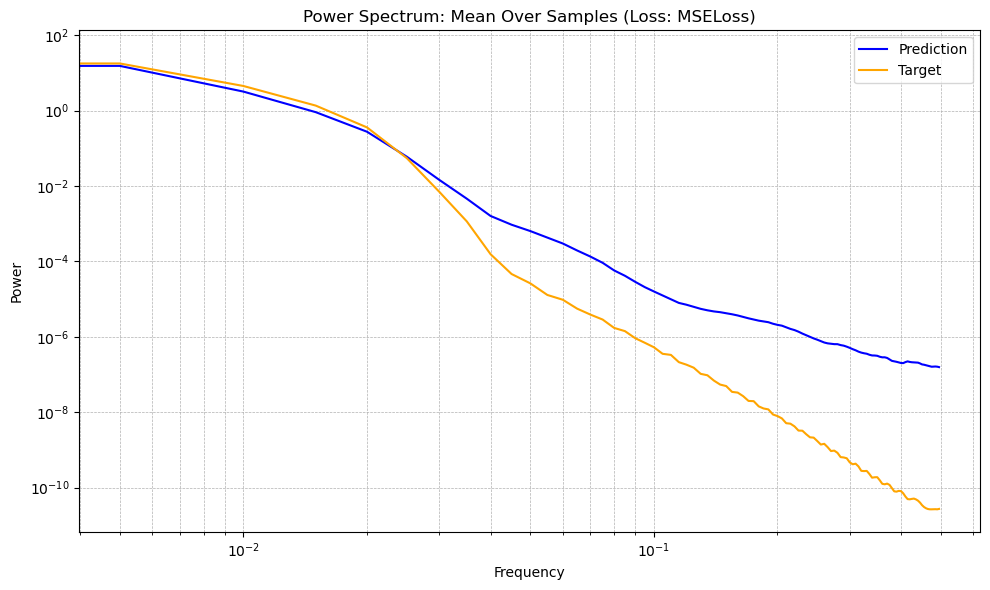

In [12]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

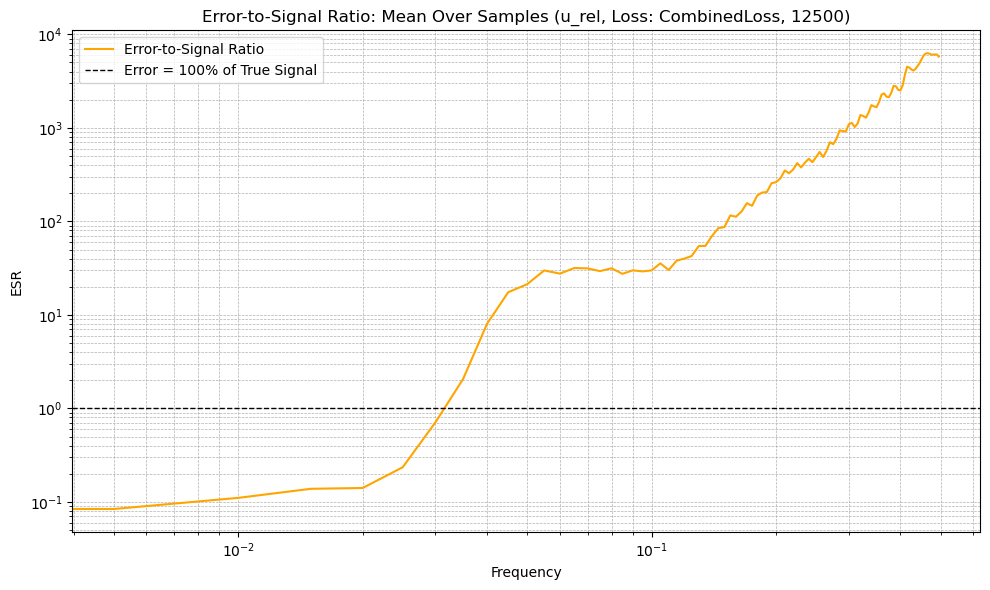

In [13]:
plot_mean_esr(sgs_pred, HF_test, loss_name="CombinedLoss", alpha_label="12500", figsize=(10, 6))

In [14]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.09857810288667679
Pearson correlation coefficient is 0.9508991475249813
r2 is 0.9041653275489807
ESR first exceeds half at None


In [11]:
r2_12500 = r2_per_sample(HF_test, sgs_pred)
r2_12500

array([0.88973475, 0.95459425, 0.86885309, 0.9471944 , 0.86703587,
       0.96132839, 0.90253085, 0.87785459, 0.90178537, 0.52528048,
       0.90652919, 0.7547726 , 0.66818237, 0.88850844, 0.84863514,
       0.94880062, 0.96381462, 0.82877529, 0.85192019, 0.91637659,
       0.88832259, 0.79929364, 0.847085  , 0.88375717, 0.79628795,
       0.90745866, 0.77875358, 0.85153508, 0.87714136, 0.481857  ,
       0.83786058, 0.93589962, 0.87369728, 0.93688691, 0.89510101,
       0.89568061, 0.76958489, 0.93459713, 0.89069939, 0.91022801,
       0.90803736, 0.91181558, 0.79340231, 0.97289211, 0.87102908,
       0.85451555, 0.92434233, 0.92336249, 0.9457314 , 0.91932893,
       0.80832857, 0.9174996 , 0.87717873, 0.85521489, 0.91114652,
       0.86628985, 0.84799057, 0.94254398, 0.94548881, 0.88535237,
       0.7006014 , 0.92126381, 0.96919495, 0.94671053, 0.93521076,
       0.92160457, 0.71806943, 0.94315469, 0.90675133, 0.89434606,
       0.88487953, 0.89279407, 0.78211319, 0.91622007, 0.94444

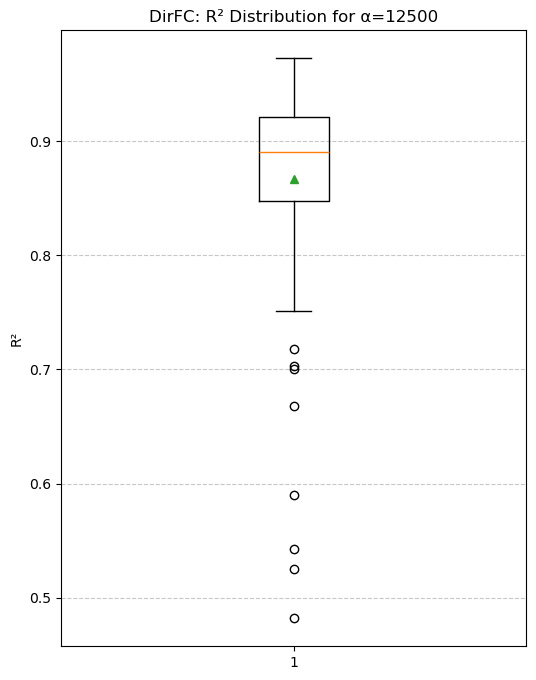

In [14]:
plt.figure(figsize=(6, 8))
plt.boxplot(r2_12500, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DirFC: R² Distribution for α=12500")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
best_index = np.argmax(r2_12500)
best_r2 = r2_12500[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9729 at index 43


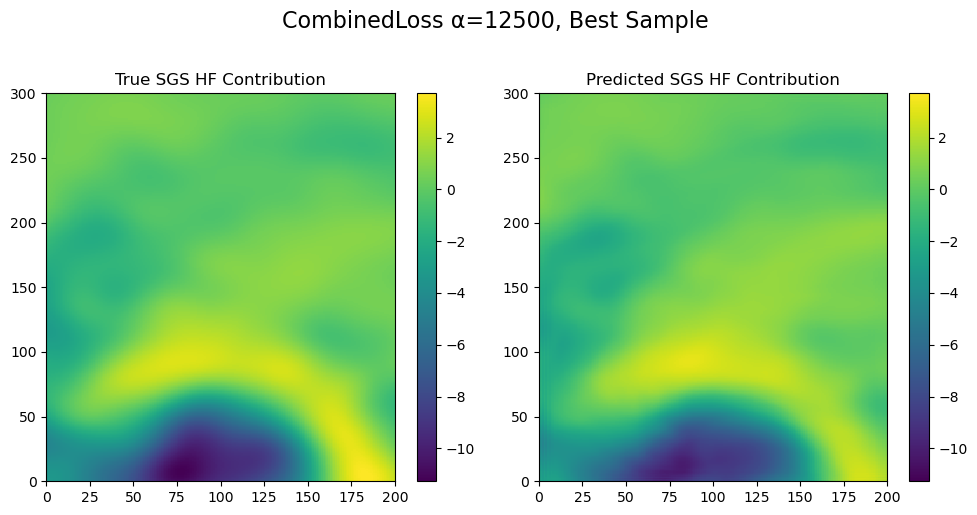

In [15]:
data1 = HF_test[best_index, :, :]
data2 = sgs_pred[best_index, :, :]

# Get shared vmin/vmax
vmin = min(data1.min(), data2.min())
vmax = max(data1.max(), data2.max())

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pc1 = axs[0].pcolor(data1, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("True SGS HF Contribution")
plt.colorbar(pc1, ax=axs[0])

pc2 = axs[1].pcolor(data2, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Predicted SGS HF Contribution")
plt.colorbar(pc2, ax=axs[1])

# Add super title
fig.suptitle("CombinedLoss α=12500, Best Sample", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

In [19]:
worst_index = np.argmin(r2_12500)
worst_r2 = r2_12500[worst_index]

print(f"Worst R² = {worst_r2:.4f} at index {worst_index}")

Worst R² = 0.4819 at index 29


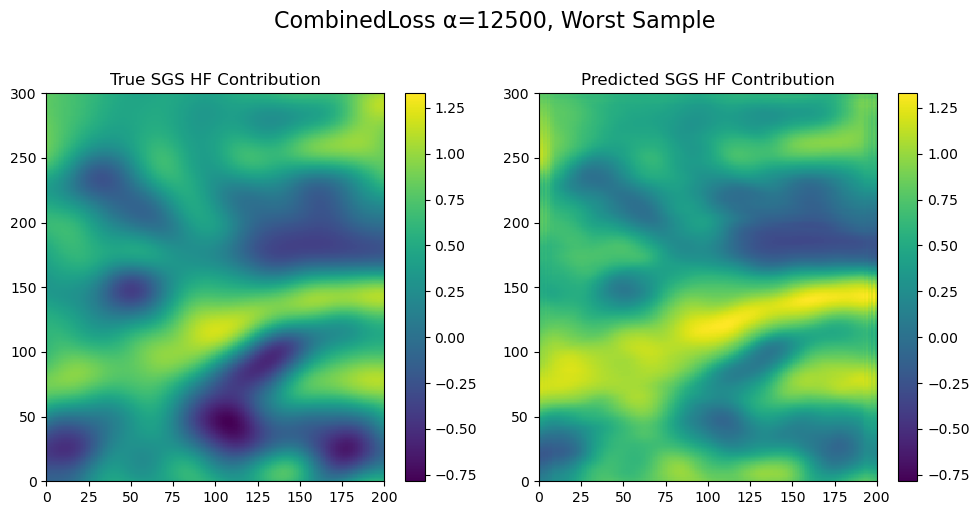

In [20]:
data1 = HF_test[worst_index, :, :]
data2 = sgs_pred[worst_index, :, :]

# Get shared vmin/vmax
vmin = min(data1.min(), data2.min())
vmax = max(data1.max(), data2.max())

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pc1 = axs[0].pcolor(data1, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("True SGS HF Contribution")
plt.colorbar(pc1, ax=axs[0])

pc2 = axs[1].pcolor(data2, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Predicted SGS HF Contribution")
plt.colorbar(pc2, ax=axs[1])

# Add super title
fig.suptitle("CombinedLoss α=12500, Worst Sample", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# Case 2: CombinedLoss (alpha=1150), Standardization

In [15]:
criterion = CombinedLoss(alpha=1150) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

In [16]:
train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CombLoss_alph1150.pth',
            n_epochs=75) # n_epochs=2000)

Trainable Parameters: 149569
Resuming from epoch 12 with best val losses []
Epoch 13, Train Loss: 5.402e+01, Val Loss: 6.536e+01, Epoch Time: 317.63s
Model saved at epoch 13
Epoch 14, Train Loss: 5.394e+01, Val Loss: 6.513e+01, Epoch Time: 330.56s
Model saved at epoch 14
Epoch 15, Train Loss: 5.218e+01, Val Loss: 6.373e+01, Epoch Time: 332.56s
Model saved at epoch 15
Epoch 16, Train Loss: 5.536e+01, Val Loss: 6.289e+01, Epoch Time: 309.08s
Model saved at epoch 16
Epoch 17, Train Loss: 5.265e+01, Val Loss: 7.106e+01, Epoch Time: 309.32s
Model saved at epoch 17
Epoch 18, Train Loss: 5.286e+01, Val Loss: 6.922e+01, Epoch Time: 305.79s
Model saved at epoch 18
Epoch 19, Train Loss: 5.436e+01, Val Loss: 7.484e+01, Epoch Time: 303.71s
Model saved at epoch 19
Epoch 20, Train Loss: 5.397e+01, Val Loss: 6.856e+01, Epoch Time: 303.50s
Model saved at epoch 20
Epoch 21, Train Loss: 5.007e+01, Val Loss: 5.636e+01, Epoch Time: 302.80s
Model saved at epoch 21
Epoch 22, Train Loss: 5.044e+01, Val Loss:

In [17]:
device = torch.device("cpu")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_CombLoss_alph1150.pth')
sgs_pred

Loaded model parameters from ./model_CombLoss_alph1150.pth


array([[[-0.4533751 , -0.59993577, -0.50790566, ...,  0.21979362,
          0.14694053,  0.25327405],
        [-0.32861632, -0.46819183, -0.3739645 , ...,  0.21792643,
          0.15245593,  0.25618386],
        [-0.29856905, -0.45338908, -0.3529688 , ...,  0.18503264,
          0.10988557,  0.22346936],
        ...,
        [ 0.7434746 ,  0.7329247 ,  0.7393075 , ...,  0.7971505 ,
          0.7606822 ,  0.81199324],
        [ 0.7443292 ,  0.7321087 ,  0.73928374, ...,  0.8198642 ,
          0.7868372 ,  0.8398653 ],
        [ 0.73497844,  0.7221193 ,  0.7301624 , ...,  0.8013904 ,
          0.76691353,  0.816175  ]],

       [[-0.5194473 , -0.53145003, -0.5419276 , ...,  0.7749123 ,
          0.7205106 ,  0.79941964],
        [-0.5024613 , -0.51124936, -0.52237356, ...,  0.8050867 ,
          0.7492447 ,  0.8307624 ],
        [-0.50664014, -0.51301235, -0.5272037 , ...,  0.7768605 ,
          0.7244032 ,  0.80525666],
        ...,
        [ 0.6159314 ,  0.6130373 ,  0.61176485, ...,  

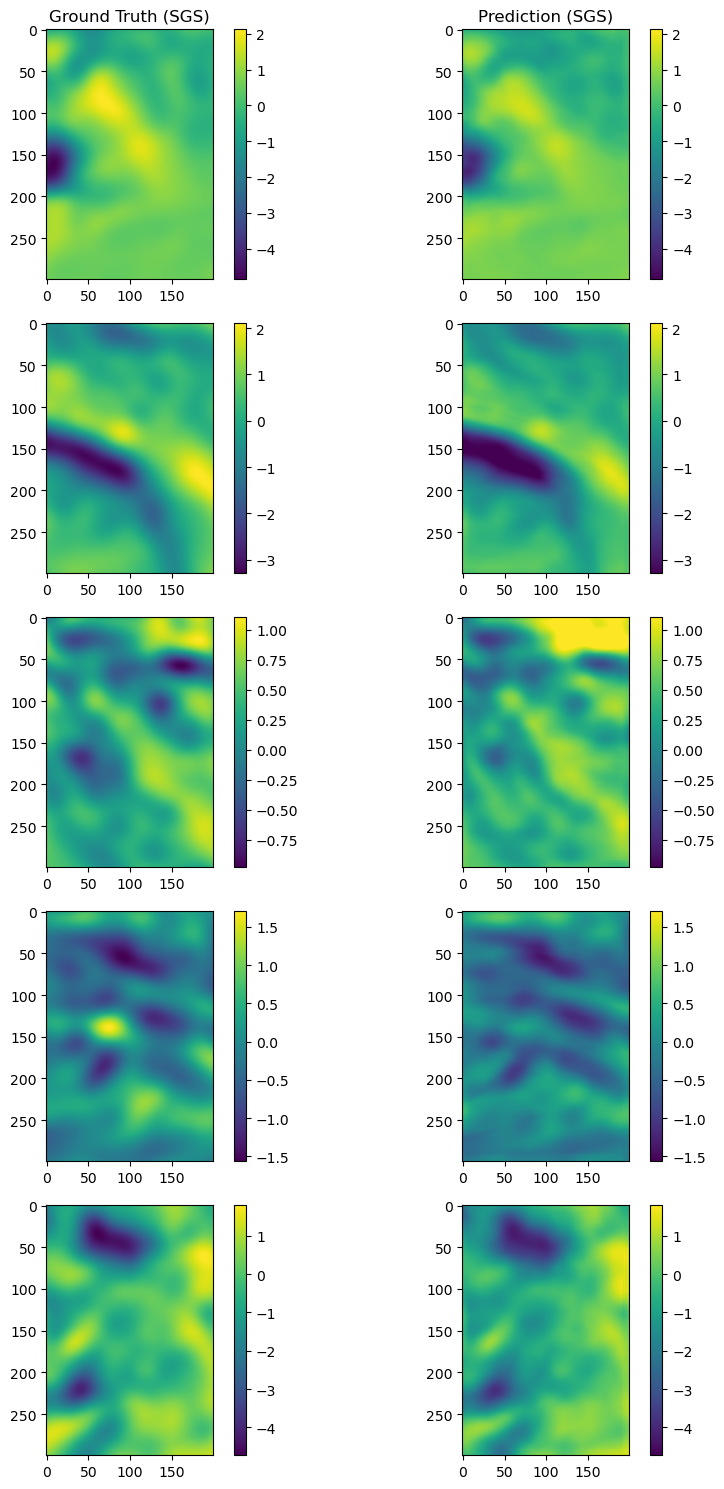

In [18]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

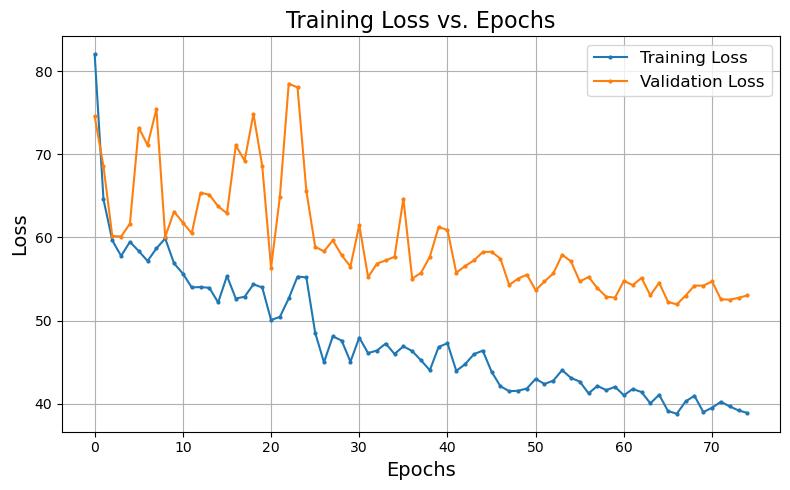

In [19]:
plot_train_val_losses(train_losses, val_losses)

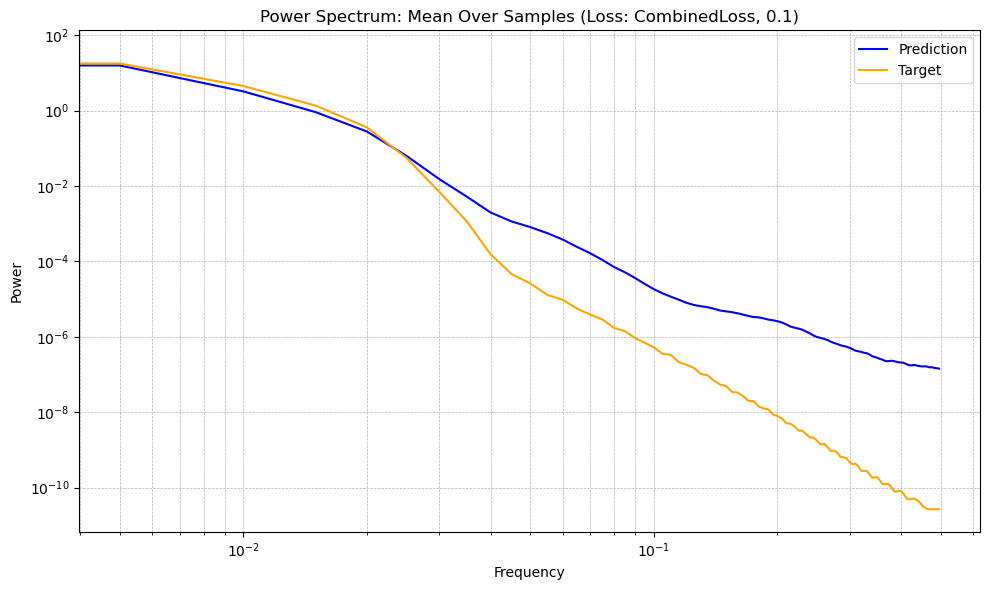

In [20]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="CombinedLoss", alpha_label="0.1", figsize=(10, 6), show_slopes=False)

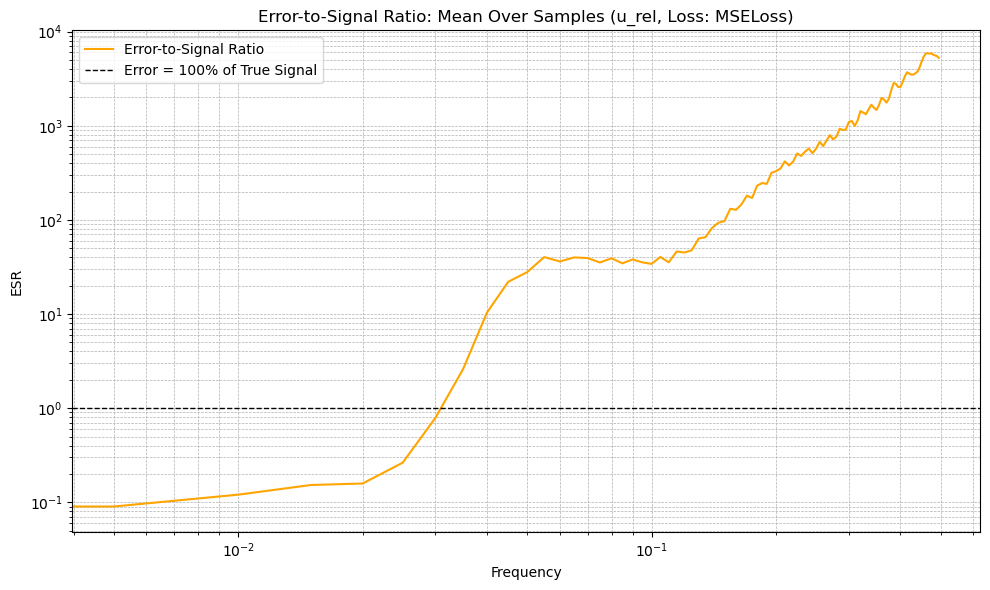

In [21]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [22]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.10745549201965332
Pearson correlation coefficient is 0.9465689132851158
r2 is 0.8955349922180176
ESR first exceeds half at None
